# Numerische Berechnung der Beta- und Dispersionsfunktionen

Da der Matrixformalismus eine numerische Berechnung der relevanten Funktionen ermoeglicht soll dies im Folgenden gemacht werden.

Dazu wird zunaechst der Ring des Ringbeschleunigers in seine Komponenten, also primaer FODO-Zellen zerlegt und dann die Beta und Dispersionsfunktion mithilfe der zugehoerigen Transfermatrizen durch die FODO-Zelle propagiert. Dazu sollen zunaechst alle relevanten Transportmatrizen aufgelistet werden.

Der allgemeine Formalismus fuer eine einzige Teilchenbahn ist:

$ \begin{pmatrix}
u_1 \\
u'_1 
\end{pmatrix} = M_{01} 
\begin{pmatrix}
u_0 \\
u'_0
\end{pmatrix}$

Da wir jedoch nicht direkt an der Bahn eines einzelnen Teilchens interressiert sind, sondern an dem Verhalten des Ganzen Teilchenpacketes muss anstelle des Teilchenvektors die Betamatrix gestellt werden. Fuer eine Transportmatrix $M_{01}$ gilt:

$ B_1 = M_{01} B_0 M_{01}^T $

mit

$ B_0 = \begin{pmatrix} \beta_0 & -\alpha_0 \\ -\alpha_0 & \gamma_0 \end{pmatrix}$

wobei $ \beta_0 = \beta(s_0)$ und $\beta(s)$ die Betafunktion und $\beta'(s)$ deren ableitung nach s ist.
Es gilt weiterhin: $\alpha_0 = \alpha(s) = -\frac{\beta'(s)}{2} $ und $\gamma_0 = \frac{1+\alpha^2(s)}{\beta(s)}$

#### Transformationsmatrix fuer eine Driftstrecke
Die Driftstrecke wirkt in gleichem masse auf Auslenkungen in x und in y richtung einer Teilchenbahn und ist definiert als:

$ M_{Dr}(s) = \begin{pmatrix} 1 & s & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & s \\ 0 & 0 & 0 & 1 \end{pmatrix} $

Da es im allgemeinen auch interressant ist die Betafunktion sowohl fuer die x als auch die y komponente zu berechnen kann auch die Betamatrix auf eine 4x4 Matrix erweitert werden.

In [1]:
# we are doing matrix multiplication so we are going to need numpy
import numpy as np
import matplotlib.pyplot as plt

def drift_space_transport_matrix(s):
    return np.array([[1, s, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, s],
                     [0, 0, 0, 1]])

def drift_space_particle_transport(x_0, s):
    m = drift_space_transport_matrix(s)
    return m @ x_0


def drift_space_betamatrix_transport(B_0, s):
    m = drift_space_transport_matrix(s)
    return m @ B_0 @ m.T

#### Transportmatrix fuer einen Quadrupol
Die Quadrupoltransportmatrix ist je nach Quadrupolstaerke in einer der beiden Ebenen fokussierend, waerend es in der anderen ebene defokussierend ist.
Daher auch die etwas kompliziertere Struktur. Alle Matrizen sind so geschrieben, sodass sie fuer alle $s$ gueltig sind, da es dank der in grossen Mengen zur verfuegung stehenden Rechenleistung nicht noetig ist vereinfachungen zu verwenden.

Horizontal fokussierender Quadrupol $k < 0$ mit $\Omega = \sqrt{\lvert k\rvert}s$:

$ M_{QF} = \begin{pmatrix} \cos{\Omega} & \frac{1}{\sqrt{\lvert k \rvert}}\sin{\Omega} & 0 & 0 \\
-\sqrt{\lvert k \rvert} \sin{\Omega} & \cos{\Omega} & 0 & 0 \\
0 & 0 & \cosh{\Omega} & \frac{1}{\sqrt{\lvert k \rvert}} \sinh{\Omega} \\
0 & 0 & \sqrt{\lvert k \rvert} \sinh{\Omega} & \cosh{\Omega} \end{pmatrix} $

Vertikal fokussierender Quadrupol $k > 0$:

$ M_{QD} = \begin{pmatrix} \cosh{\Omega} & \frac{1}{\sqrt{k}}\sinh{\Omega} & 0 & 0 \\
\sqrt{k} \sinh{\Omega} & \cosh{\Omega} & 0 & 0 \\
0 & 0 & \cos{\Omega} & \frac{1}{\sqrt{k}} \sin{\Omega} \\
0 & 0 & -\sqrt{k} \sin{\Omega} & \cos{\Omega} \end{pmatrix} $

In [2]:
def quad_transport_matrix(s, k):
    sk = np.sqrt(np.abs(k))
    a = np.array([[np.cos(sk*s), 1/sk*np.sin(sk*s)],
                  [-sk*np.sin(sk*s), np.cos(sk*s)]])
    b = np.array([[np.cosh(sk*s), 1/sk*np.sinh(sk*s)],
                  [sk*np.sinh(sk*s), np.cosh(sk*s)]])
    # horizontal fokussierend
    
    if k < 0:
        mat = np.block([[a, np.zeros((2, 2))],
                        [np.zeros((2, 2)), b],
                       ])
    # vertikal fokussierend
    else:
        mat = np.block([[b, np.zeros((2, 2))],
                        [np.zeros((2, 2)), a],
                       ])
    return mat

def quad_particle_transport(x_0, s, k):
    m = quad_transport_matrix(s,k)
    return m @ x_0

def quad_betamatrix_transport(B_0, s, k):
    m = quad_transport_matrix(s, k)
    return m @ B_0 @ m.T

#### Transportmatrix fuer einen Dipol
Bei der Transportmatrix eines Dipols muss noch der ablenkwinkel aus der Laenge und dem Ablenkradius errechnet werden.
Es gilt
$ \theta = \frac{s}{\rho} $ wobei $s$ die strecke des Teilchens entlang des Dipols ist.

Ein Dipol wirkt prinzipiell nur auf die Horizontale Bahn des Teilchens, wesshalb die Dipolmatrix asymmetrisch aussieht, wenn sie als 4 x 4 matrix geschrieben wird.

$ M_{Dipol} = \begin{pmatrix} \cos{\theta} & \rho \sin{\theta} & 0 & 0 \\ -\frac{1}{\rho}\sin{\theta} & \cos{\theta} & 0 & 0 \\ 0 & 0 & 1 & s \\ 0 & 0 & 0 & 1\end{pmatrix} $

In [3]:
def dipol_transport_matrix(s, r):
    x = np.array([[np.cos(s/r), r*np.sin(s/r)],
                   [-1/r*np.sin(s/r), np.cos(s/r)]])
    y = np.array([[1, s],
                  [0, 1]])
    return np.block([[x, np.zeros((2, 2))],
                     [np.zeros((2, 2)), y]])

def dipol_particle_transport(x_0, s, r):
    m = dipol_transport_matrix(s, r)
    return m @ x_0

def dipol_betamatrix_transport(B_0, s, r):
    m = dipol_transport_matrix(s, r)
    return m @ B_0 @ m.T

## Berechnung der Dispersionsfunktion
Die Dispersion kann ebenfalls als Matrix formuliert werden. Da die Dispersion in erster linie vom kruemungsradius der Bahn beeinflusst wird, koennen alle magnete ausser der Dipole vernachlaessigt werden. Die Dispersionsmatrizen sind folglich fuer alle strecken identisch zu einer Driftstrecke, ausser beim dipol.

Die Dipol Dispersionsmatrix ist wie folgt definiert.

$ MD = \begin{pmatrix} \cos{\theta} & \rho\sin{\theta} & \rho \left(1-\cos{\theta}\right) \\
-\frac{1}{\rho}\sin{\theta} & \cos{\theta} & \sin{\theta} \\
0 & 0 & 1 \end{pmatrix}$

Sie transportiert den Dispersionsvector

$\vec{D} = \begin{pmatrix} D_0 \\ D'_0 \\ \frac{\Delta p}{p_0} \end{pmatrix}$ 

entlang des Maschinenorbits

In [4]:
def dipol_dispersion_transport(d_0, s, r):
    m = np.array([[np.cos(s/r), r*np.sin(s/r), r*(1-np.cos(s/r))],
                     [-(1/r)*np.sin(s/r), np.cos(s/r), np.sin(s/r)],
                     [0, 0, 1]
                    ])
    return m @ d_0

def quad_dispersion_transport(d_0, s):
    m = np.array([[1, s, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
    return m @ d_0

def drift_dispersion_transport(d_0, s):
    return quad_dispersion_transport(d_0, s)

## Test der Funktionen
Im Folgenden sollen die oben beschriebenen Funktionen getestet werden.
Zunaechst soll eine bahnkurve fuer einen Dipol berechnet werden, wobei eine 180 grad wende gemacht werden soll. Das Teilchen soll dabei lediglich ein klein wenig von der sollbahn versetzt sein und parallel zur sollbahn fliegen

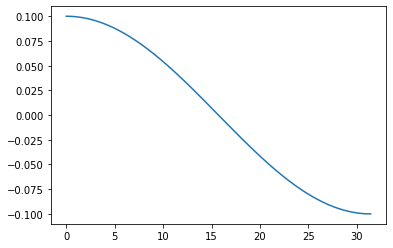

In [5]:
r = 10
s_max = np.pi * r
s = np.linspace(0, s_max, 1000)
x_0 = [0.1, 0, 0, 0] 

x_s = [dipol_particle_transport(x_0, s_i, r)[0] for s_i in s]
plt.plot(s, x_s)

wie wir sehen hat die abweichung gerade das vorzeichen gewechselt, genau wie erwartet
fuer den quadrupol kann nun geprueft werden, ob zwei parallele strahlen vor dem quadrupol nach dem quadrupol in der einen ebene zusammenlaufen waehrend sie in der anderen ebene gestreut werden. Es soll daran erinnert werden, dass $\frac{1}{f} = -kl$

[ 0.09016556 -0.00966998  0.          0.        ]
[-0.09016556  0.00966998  0.          0.        ]
[0.         0.         0.11016778 0.01033668]
[ 0.          0.         -0.11016778 -0.01033668]


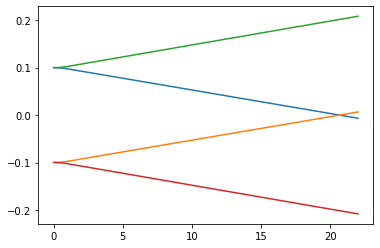

In [6]:
# horizontal fokussierend, vertikal defokussierend
k = -0.05
l = 1
s_max = -1/(k*l) + l
s_in_quad = np.linspace(0, l, 1000)
s_outside_quad = np.linspace(0, s_max, 1000)
x = [[0.1, 0, 0, 0], [-0.1, 0, 0, 0]]
y = [[0, 0, 0.1, 0], [0, 0, -0.1, 0]]
tracks = [[], [], [], []]

for i, particle in enumerate(x):
    for s_i in s_in_quad:
        tracks[i].append(quad_particle_transport(particle, s_i, k)[0])
    x[i] = quad_particle_transport(particle, l, k)

for i, particle in enumerate(y):
    for s_i in s_in_quad:
        tracks[i+len(x)].append(quad_particle_transport(particle, s_i, k)[2])
    y[i] = quad_particle_transport(particle, l, k)
    
print(quad_particle_transport(x[0], l, k))
print(quad_particle_transport(x[1], l, k))
print(quad_particle_transport(y[0], l, k))
print(quad_particle_transport(y[1], l, k))

for i, particle in enumerate(x):
    for s_i in s_outside_quad:
        x_i = drift_space_particle_transport(particle, s_i)
        tracks[i].append(x_i[0])
        #print(x_i)

for i, particle in enumerate(y):
    for s_i in s_outside_quad:
        x_i = drift_space_particle_transport(particle, s_i)
        tracks[i+len(x)].append(x_i[2])
        #print(x_i[2])

s_outside_quad += l
s = np.concatenate((s_in_quad, s_outside_quad), axis=0)
for track in tracks:
    plt.plot(s, track)
plt.show()

jetzt wo wir wissen, dass die entsprechenden Funktionen auch das tun was sie sollen, koennen wir inzwischen bereits Teilchenbahnen durch den Beschleuniger verfolgen. Als letztes muss noch die  Dispersionsfunktion getestet werden. Wir nehmen an, dass die Dispersionsfunktion nur in Dipolen eine evolution erfaehrt
Es soll also jetzt die dispersionsentwicklung in einem Dipol betrachtet werden.

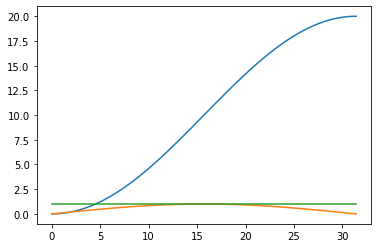

In [7]:
r = 10
s_max = np.pi * r
s = np.linspace(0, s_max, 1000)
d_0 = [0.00, 0.00, 1] 

d_s = [dipol_dispersion_transport(d_0, s_i, r) for s_i in s]
plt.plot(s, d_s)
plt.show()

Wie man sehen kann ist die Dispersionsabweichung periodisch ist was zumindest fuer den Fall einer Kreisbahn immerhin sinnvoll erscheint.

## Die Fodo zelle
Aus dem Lattice Design soll nun die Fodo zelle extrahiert und als "proof of concept" durchgerechnet und die resultierende Betafunktion graphisch dargestellt werden.
Fuer die FODO Zelle wurden folgende Parameter bestimmt

In [8]:
quad_strength = 0.01414213562373095 # abs(k)
quad_length = 1 # l
bending_radius = 639.8028712294193
dipole_length = 14
cell_dipole_count = 6
fodo_length = 100

with these numbers and a few assumptions on the part of the layout it is possible to calculate either the individual particle track or the beta function for the cell. From the Betafunction the other relevant quantities can be derived.

It makes sense here to define classes representing the different magnet types. So before being properly able to model the FODO cell it seems reasonable to first write the classes.

In [169]:
class Quadrupole():
    def __init__(self, k, l):
        self.strength = k
        self.length = l
    
    def __call__(self, x_0, s):
        #print(x_0, type(x_0))
        if s > self.length:
            raise ValueError("distance outside of quad")
        if x_0.shape == (4, 4):
            return quad_betamatrix_transport(x_0, self.length, self.strength)
        elif x_0.shape == (4,):
            return quad_particle_transport(x_0, self.length, self.strength)
        else:
            raise ValueError("wrong shape of input vector. Neither particle vector nor Beta-matrix")
    
    def propagate(self, x_0):
        return self(x_0, self.length)

In [157]:
# I am assuming sector magnets here so that l is the distance that the beam travels through the dipole, not its actual length
class Dipole():
    def __init__(self, r, l):
        self.bending_radius = r
        self.length = l
        
    def __call__(self, x_0, s):
        if s > self.length:
            raise ValueError("distance outside of dipole")
        if x_0.shape == (4, 4):
            return dipol_betamatrix_transport(x_0, s, self.bending_radius)
        elif x_0.shape == (4,):
            return dipol_particle_transport(x_0, s, self.bending_radius)
        else:
            raise ValueError("wrong shape of input vector. Neither particle vector nor Beta-matrix")

    def propagate(self, x_0):
        return self(x_0, self.length)

In [158]:
class Driftspace():
    def __init__(self, l):
        self.length = l
        print(self.length)
    
    def __call__(self, x_0, s):
        if s > self.length:
            raise ValueError("distance outside of driftspace")
        if x_0.shape == (4, 4):
            return drift_space_betamatrix_transport(x_0, s)
        elif x_0.shape == (4,):
            return drift_space_particle_transport(x_0, s)
        else:
            raise ValueError("wrong shape of input vector. Neither particle vector nor Beta-matrix")
    
    def propagate(self, x_0):
        return self(x_0, self.length)

With the three primary components abstracted into classes the class representing the FODO cell can be somewhat elegantly defined.
As the basic structure is known it should only be neccessary to define the length of the cell, the length of the quadrupole and the length and position of the dipoles in the structure as well as the strengts/bending radii of the magnets.

As this is not a finished library I will not include usability features like bounds checks and similar things but only implement the bare funktionality.

In [196]:
import itertools as it

class FODOCell():
    def __init__(self, cell_length, quad_length, dipole_starting_positions, dipole_lengths, k, r):
        self.length = cell_length
        self.elements = []
        try:
            q1 = Quadrupole(k[0], quad_length)
            q2 = Quadrupole(k[1], quad_length)
        except TypeError:
            q1 = Quadrupole(-k, quad_length)
            q2 = Quadrupole(k, quad_length)
        self.elements.append((0, q1))
        self.elements.append((cell_length/2, q2))
        try:
            dipole_vals = zip(dipole_starting_positions, dipole_lengths, r)
        except TypeError:
            dipole_vals = zip(dipole_starting_positions, dipole_lengths, it.repeat(r, len(dipole_starting_positions)))
        for dv in dipole_vals:
            d = Dipole(dv[2], dv[1])
            self.elements.append((dv[0], d))
        self.elements = sorted(self.elements, key=lambda d: d[0])
        neighboring_magnets = zip(self.elements[:-1], self.elements[1:])
        drift_spaces = []
        for nm in neighboring_magnets:
            end_of_first_magnet = nm[0][0] + nm[0][1].length
            start_of_second_magnet = nm[1][0]
            drift_spaces.append((end_of_first_magnet, Driftspace(start_of_second_magnet - end_of_first_magnet)))
        for d in drift_spaces:
            self.elements.append(d)
        self.elements = sorted(self.elements, key=lambda m: m[0])
        end_of_last_cell = self.elements[-1][0] + self.elements[-1][1].length
        if end_of_last_cell < self.length:
            self.elements.append((end_of_last_cell, Driftspace(self.length - end_of_last_cell)))
        
    def propagate(self, x_0):
        x = x_0
        v = [x_0]
        for elem in self.elements:
            x = elem[1].propagate(x)
            v.append(x)
        return v

    def __call__(self, x_0, s):
        boundary_particle_state_vectors = self.propagate(x_0)
        cell_idx = 0
        while s > self.elements[cell_idx][0] + self.elements[cell_idx][1].length:
            cell_idx += 1
            #print(cell_idx)
        s = s - self.elements[cell_idx][0]
        return self.elements[cell_idx][1](boundary_particle_state_vectors[cell_idx], s)
    
    def eval_at_points(self, x_0, points):
        boundary_particle_state_vectors = self.propagate(x_0)
        x_vs = []
        for p in points:
            x_vs.append(self(x_0, p))
        return x_vs

    def plot(self, x_0, plot_points):
        xv = self.eval_at_points(x_0, plot_points)
        if x_0.shape == (4,):
            xx, xy = list(zip(*[(x[0], x[2]) for x in xv]))
        elif x_0.shape == (4, 4):
            xx, xy = list(zip(*[(x[0,0], x[2, 2]) for x in xv]))
        else:
            raise ValueError("wrong shape of input vector. Neither particle vector nor Beta-matrix")
        plt.plot(plot_points, xx)
        plt.plot(plot_points, xy)
        plt.show()

In [197]:
fdc = FODOCell(100, 1, [2+3/4, 17+6/4, 32+9/4, 52+3/4, 67+6/4, 82+9/4], [14, 14, 14, 14, 14, 14], quad_strength, bending_radius)
fdc.elements

1.75
1.75
1.75
1.75
1.75
1.75
1.75
1.75


[(0, <__main__.Quadrupole at 0x7f58251df210>),
 (1, <__main__.Driftspace at 0x7f5826602390>),
 (2.75, <__main__.Dipole at 0x7f5824d8b210>),
 (16.75, <__main__.Driftspace at 0x7f5826602f90>),
 (18.5, <__main__.Dipole at 0x7f5824d8b4d0>),
 (32.5, <__main__.Driftspace at 0x7f5826602a10>),
 (34.25, <__main__.Dipole at 0x7f5824d8b290>),
 (48.25, <__main__.Driftspace at 0x7f5826602e10>),
 (50.0, <__main__.Quadrupole at 0x7f58251dfb50>),
 (51.0, <__main__.Driftspace at 0x7f5826602690>),
 (52.75, <__main__.Dipole at 0x7f5825371b10>),
 (66.75, <__main__.Driftspace at 0x7f5826602090>),
 (68.5, <__main__.Dipole at 0x7f5830a5f7d0>),
 (82.5, <__main__.Driftspace at 0x7f5830a63110>),
 (84.25, <__main__.Dipole at 0x7f5830a5f050>),
 (98.25, <__main__.Driftspace at 0x7f58267c3d90>)]

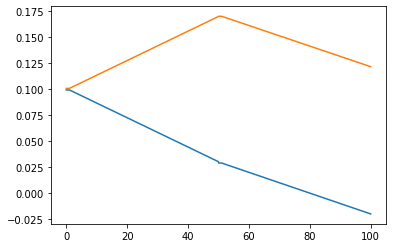

In [198]:
s = np.linspace(0, 100, 10000)
fdc.plot(np.array([.1, 0, .1, 0]), s)

So now that it seems that the tracking simulation works we can focus our attention on the Beta matrix. First we need a way to constuct the beta matix from an initial "Beta-track" given by $\beta(s_0)$ and $\beta'(s_0)$.

In [172]:
def construct_beta_matrix(bv):
    bx = bv[0]
    by = bv[2]
    dbx_ds = bv[1]
    dby_ds = bv[3]
    ax = -dbx_ds/2
    gx = (1+ax**2)/bx
    ay = -dby_ds/2
    gy = (1+ay**2)/by
    return np.array([[bx, -ax, 0, 0], [-ax, gx, 0, 0], [0, 0, by, -ay], [0, 0, -ay, gy]])

now we have a description for the betamatrix and only need to plug in values for the Betafunction at a specifc point in the accellerator. Let's first run the betamatrix through the FODO cell that we have created.

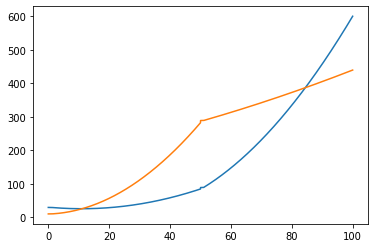

In [173]:
# at the beginning of the FODO cell the betafunction does not diverge or converge
fdc.plot(construct_beta_matrix([30, 0, 10, 0]), s)

looks sensible and we definitely see the dipoles

## Putting it together to a multi cell structure
now that we have the fodo cells down and they seem to be working we need to build a structure that contains them. As we are definitely modelilg real world things I think that modeling these things as classes is a good idea. So like with the quadrupoles and the FODO cell I'll define a class to contain the entire accelerator

In [204]:
class Accelerator():
    def __init__(self, cells, ring=True):
        self.ring = ring
        cell_with_dist = []
        c = 0
        for cell in cells:
            cell_with_dist.append((c, cell))
            c += cell.length
        self.elements = cell_with_dist
        self.length = sum([cell.length for cell in cells])
    
    def propagate(self, x_0):
        xv = [x_0]
        x = x_0
        for cell in self.elements:
            x = cell[1].propagate(x)[-1]
            xv.append(x)
        return xv
    
    def eval_at_points(self, x_0, points):
        boundary_particle_state_vectors = self.propagate(x_0)
        x_vs = []
        for p in points:
            cell_idx = 0
            while p > self.elements[cell_idx][0] + self.elements[cell_idx][1].length:
                cell_idx += 1
                #print(cell_idx)
            s = p - self.elements[cell_idx][0]
            x_vs.append(self.elements[cell_idx][1](boundary_particle_state_vectors[cell_idx], s))
        return x_vs
    
    def plot(self, x_0, plot_points):
        xv = self.eval_at_points(x_0, plot_points)
        if x_0.shape == (4,):
            xx, xy = list(zip(*[(x[0], x[2]) for x in xv]))
        elif x_0.shape == (4, 4):
            xx, xy = list(zip(*[(x[0,0], x[2, 2]) for x in xv]))
        else:
            raise ValueError("wrong shape of input vector. Neither particle vector nor Beta-matrix")
        plt.plot(plot_points, xx)
        plt.plot(plot_points, xy)
        plt.show()

In [205]:
acc = Accelerator([fdc, fdc, fdc, fdc])

In [206]:
acc.length

400

In [207]:
s = np.linspace(0, 400, 400000)

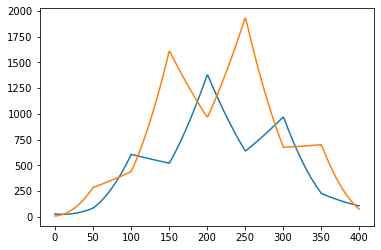

In [208]:
acc.plot(construct_beta_matrix([30, 0, 10, 0]), s)